# Morphology and initial fluorescence


--- СПИСОК КАНАЛОВ ---
[0] -> FSC-H
[1] -> SSC-H
[2] -> FITC-H
[3] -> PE-H
[4] -> PE-Texas Red-H
[5] -> PE-Cy5-H
[6] -> PE-Cy7-H
[7] -> FSC-A
[8] -> SSC-A
[9] -> FITC-A
[10] -> PE-A
[11] -> PE-Texas Red-A
[12] -> PE-Cy5-A
[13] -> PE-Cy7-A
[14] -> FSC-W
[15] -> SSC-W
[16] -> FITC-W
[17] -> PE-W
[18] -> PE-Texas Red-W
[19] -> PE-Cy5-W
[20] -> PE-Cy7-W

Рассчитываю оптимальные границы осей...


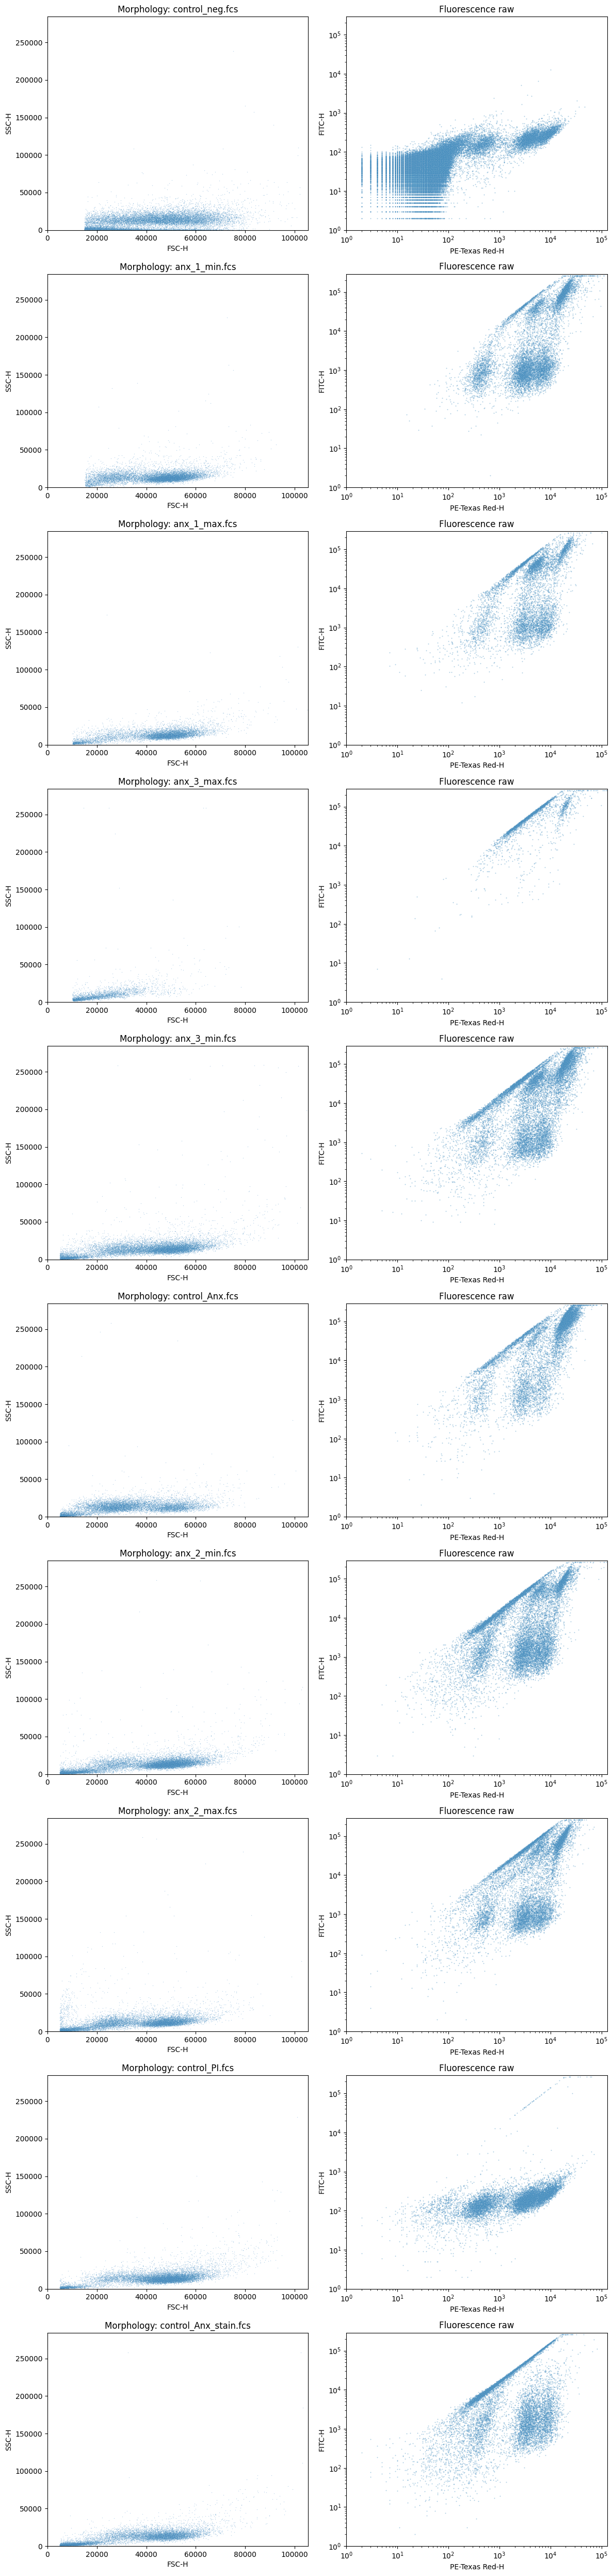

In [13]:
import zipfile, os, tempfile, fcsparser, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

zip_path = 'fcs.zip'

def get_limit(archive, files, channel_idx, percentile=99.9):
    """Находит статистический предел (99.9%) для канала по всем файлам."""
    all_max_values = []
    with tempfile.TemporaryDirectory() as tmpdir:
        for f in files:
            path = archive.extract(f, tmpdir)
            _, df = fcsparser.parse(path)
            p_val = np.percentile(df.iloc[:, channel_idx], percentile)
            all_max_values.append(p_val)
    return max(all_max_values) * 1.1

with zipfile.ZipFile(zip_path, 'r') as archive:
    fcs_files = sorted([f for f in archive.namelist() if f.endswith('.fcs')])
    
    with tempfile.TemporaryDirectory() as tmpdir:
        _, df_sample = fcsparser.parse(archive.extract(fcs_files[0], tmpdir))
        channels = list(df_sample.columns)

    print("\n--- СПИСОК КАНАЛОВ ---")
    for i, ch in enumerate(channels): print(f"[{i}] -> {ch}")
    
    fsc_idx = int(input("№ для FSC-H (ось X морфологии): "))
    ssc_idx = int(input("№ для SSC-H (ось Y морфологии): "))
    x_idx = int(input("№ для PI/Texas Red (ось X флуоресценции): "))
    y_idx = int(input("№ для FITC (ось Y флуоресценции): "))
    
    print("\nРассчитываю оптимальные границы осей...")
    lim_fsc = get_limit(archive, fcs_files, fsc_idx)
    lim_ssc = get_limit(archive, fcs_files, ssc_idx)
    lim_pi = get_limit(archive, fcs_files, x_idx)
    lim_fitc = get_limit(archive, fcs_files, y_idx)

    num_samples = len(fcs_files)
    # Теперь в сетке всего 2 колонки
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 5 * num_samples))
    if num_samples == 1: axes = np.expand_dims(axes, axis=0)

    for i, file_path in enumerate(fcs_files):
        with tempfile.TemporaryDirectory() as tmpdir:
            _, df = fcsparser.parse(archive.extract(file_path, tmpdir))
            ch_fsc, ch_ssc = channels[fsc_idx], channels[ssc_idx]
            ch_pi, ch_fitc = channels[x_idx], channels[y_idx]

            # --- 1. Морфология (FSC vs SSC) ---
            sns.scatterplot(data=df, x=ch_fsc, y=ch_ssc, s=1, alpha=0.3, ax=axes[i, 0])
            axes[i, 0].set_xlim(0, lim_fsc)
            axes[i, 0].set_ylim(0, lim_ssc)
            axes[i, 0].set_title(f"Morphology: {os.path.basename(file_path)}")

            # --- 2. Флуоресценция (PI vs FITC) ---
            # Убираем значения <= 1 для корректного логарифма
            df_log = df[(df[ch_pi] > 1) & (df[ch_fitc] > 1)]
            sns.scatterplot(data=df_log, x=ch_pi, y=ch_fitc, s=2, alpha=0.4, ax=axes[i, 1])
            axes[i, 1].set_xscale('log'); axes[i, 1].set_yscale('log')
            axes[i, 1].set_xlim(1, lim_pi)
            axes[i, 1].set_ylim(1, lim_fitc)
            axes[i, 1].set_title("Fluorescence raw")

    plt.tight_layout()
    plt.show()

# Gating debris

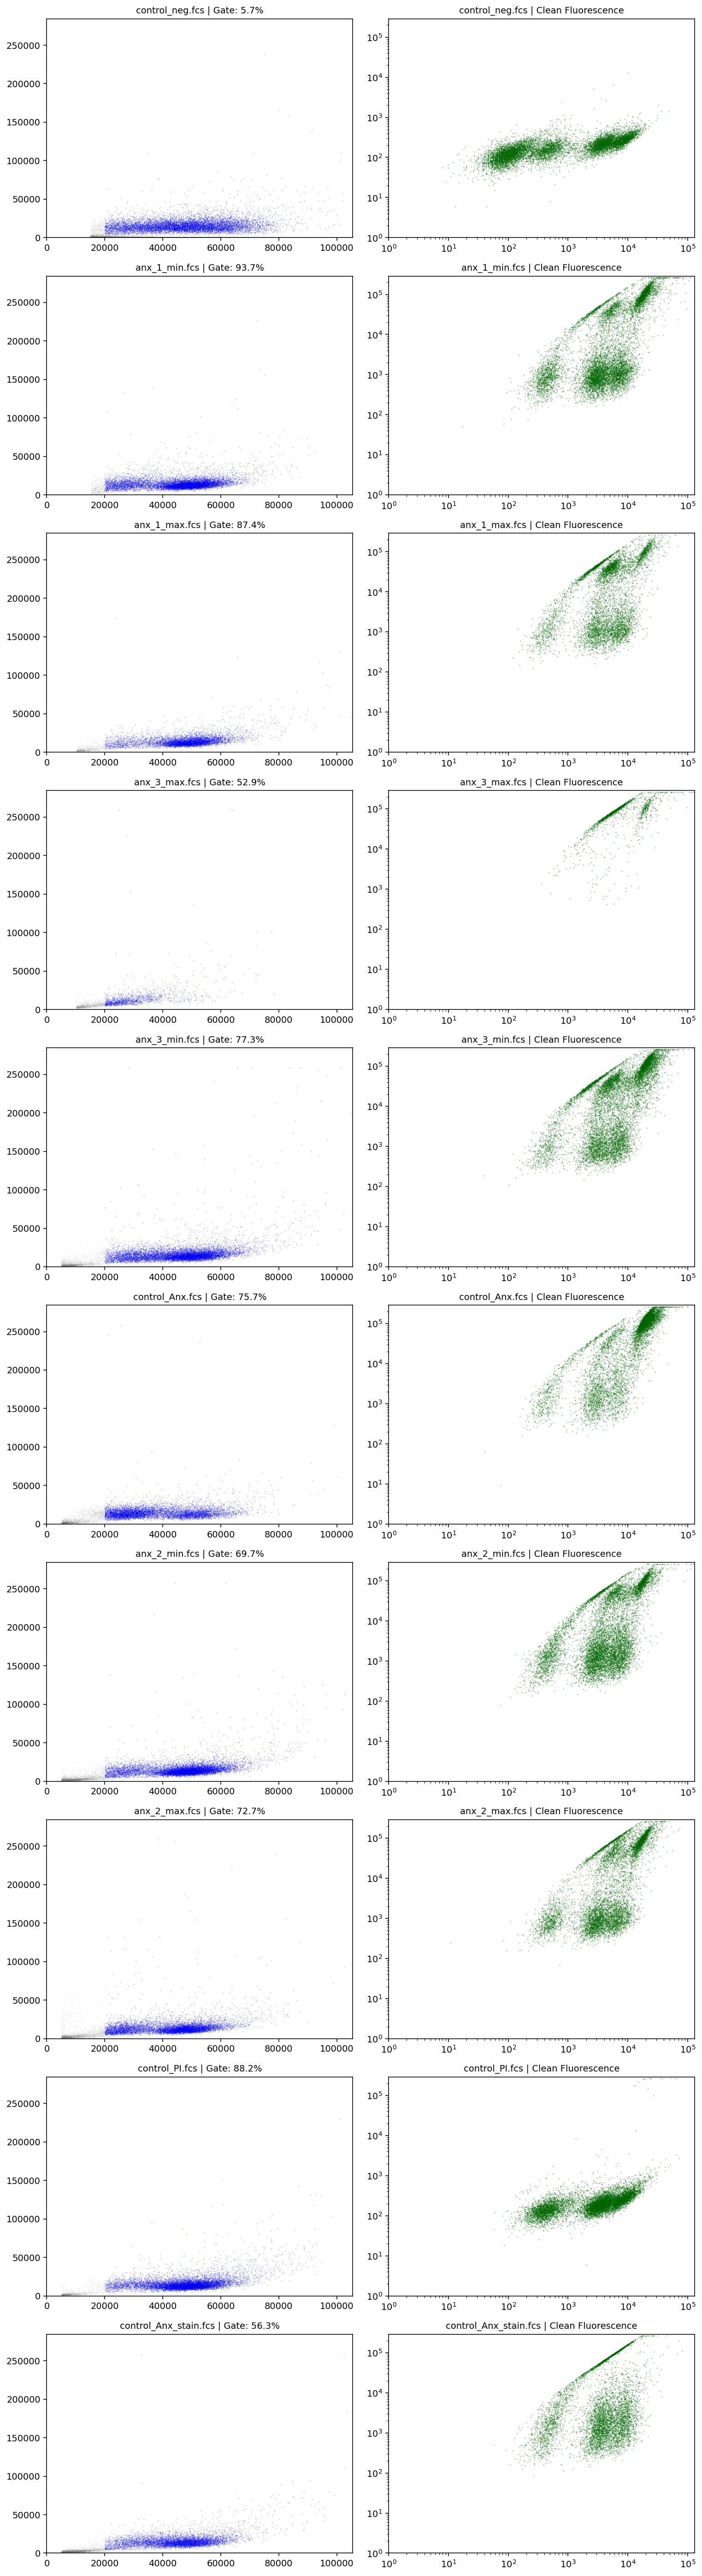

In [24]:
# --- ВВОД ПАРАМЕТРОВ ФИЛЬТРАЦИИ ---
fsc_gate = int(input("Введите порог FSC-H: "))
ssc_gate = int(input("Введите порог SSC-H: "))

filtered_samples = [] 
plt.rcParams['figure.dpi'] = 140 # Еще чуть выше четкость

fig, axes = plt.subplots(num_samples, 2, figsize=(11, 4 * num_samples))
if num_samples == 1: axes = np.expand_dims(axes, axis=0)

with zipfile.ZipFile(zip_path, 'r') as archive:
    for i, file_path in enumerate(fcs_files):
        sample_name = os.path.basename(file_path)
        
        with tempfile.TemporaryDirectory() as tmpdir:
            _, df = fcsparser.parse(archive.extract(file_path, tmpdir))
            df_clean = df[(df[ch_fsc] >= fsc_gate) & (df[ch_ssc] >= ssc_gate)].copy()
            filtered_samples.append({'df': df_clean, 'name': sample_name})
            
            # 1. Морфология
            # linewidths=0 убирает пиксельную "грязь" вокруг точек
            axes[i, 0].scatter(df[ch_fsc], df[ch_ssc], s=0.8, alpha=0.1, color='grey', linewidths=0)
            axes[i, 0].scatter(df_clean[ch_fsc], df_clean[ch_ssc], s=0.8, alpha=0.3, color='blue', linewidths=0)
            axes[i, 0].set_xlim(0, lim_fsc); axes[i, 0].set_ylim(0, lim_ssc)
            axes[i, 0].set_title(f"{sample_name} | Gate: {len(df_clean)/len(df)*100:.1f}%", fontsize=10)

            # 2. Флуоресценция
            df_log = df_clean[(df_clean[ch_pi] > 1) & (df_clean[ch_fitc] > 1)]
            axes[i, 1].scatter(df_log[ch_pi], df_log[ch_fitc], s=1.5, alpha=0.4, color='darkgreen', linewidths=0)
            axes[i, 1].set_xscale('log'); axes[i, 1].set_yscale('log')
            axes[i, 1].set_xlim(1, lim_pi); axes[i, 1].set_ylim(1, lim_fitc)
            axes[i, 1].set_title(f"{sample_name} | Clean Fluorescence", fontsize=10)

plt.tight_layout()
plt.show()

# Compensation

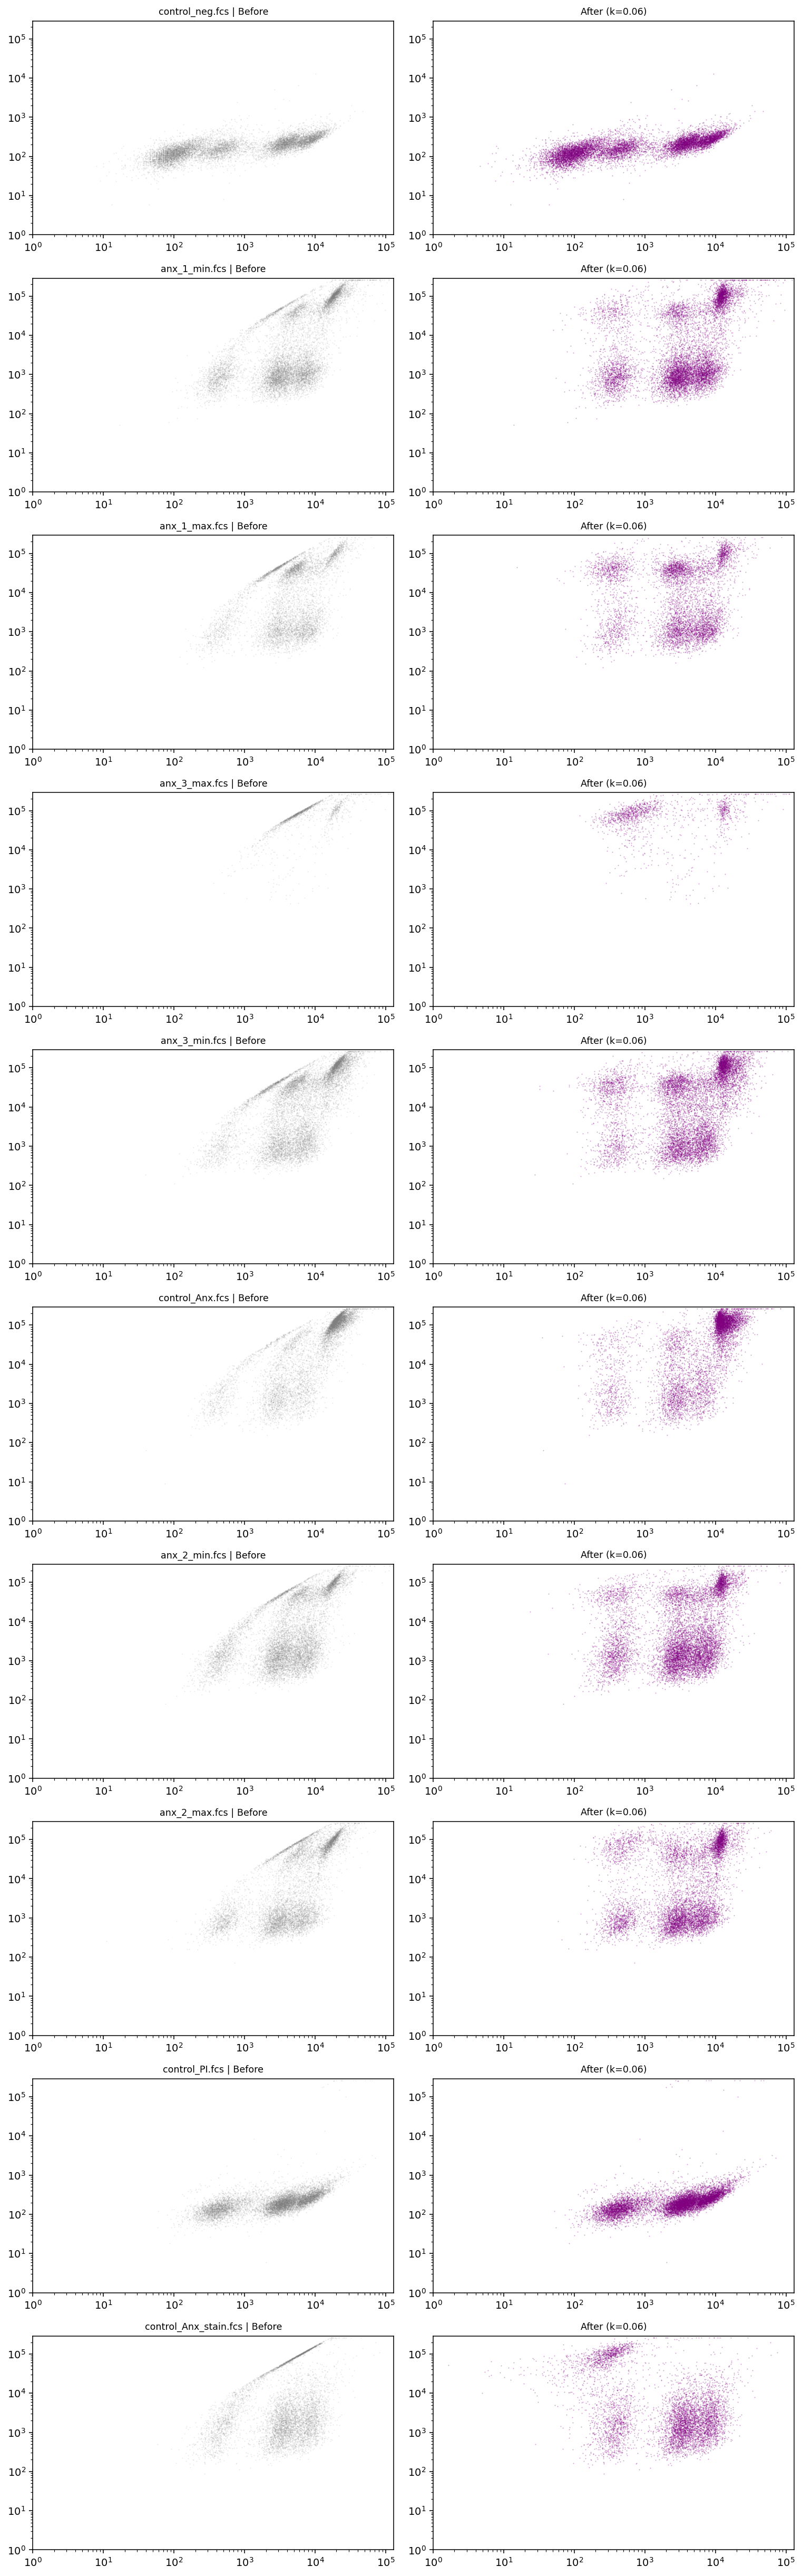

In [ ]:
comp_value = float(input("Введите коэф. компенсации (0.01 - 0.15): "))

plt.rcParams['figure.dpi'] = 140
fig, axes = plt.subplots(num_samples, 2, figsize=(11, 3.5 * num_samples))
if num_samples == 1: axes = np.expand_dims(axes, axis=0)

for i, sample in enumerate(filtered_samples):
    df_raw = sample['df'].copy()
    df_c = sample['df'].copy()
    df_c[ch_pi] = (df_c[ch_pi] - (comp_value * df_c[ch_fitc])).clip(lower=1)
    sample['df_comp'] = df_c
    
    raw_log = df_raw[(df_raw[ch_pi] > 1) & (df_raw[ch_fitc] > 1)]
    comp_log = df_c[(df_c[ch_pi] > 1) & (df_c[ch_fitc] > 1)]
    
    # Сравнение До/После с четкими точками
    axes[i, 0].scatter(raw_log[ch_pi], raw_log[ch_fitc], s=1, alpha=0.2, color='grey', linewidths=0)
    axes[i, 0].set_title(f"{sample['name']} | Before", fontsize=9)
    
    axes[i, 1].scatter(comp_log[ch_pi], comp_log[ch_fitc], s=1, alpha=0.4, color='purple', linewidths=0)
    axes[i, 1].set_title(f"After (k={comp_value})", fontsize=9)

    for ax in axes[i]:
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.set_xlim(1, lim_pi); ax.set_ylim(1, lim_fitc)

plt.tight_layout()
plt.show()

# Colors and gates

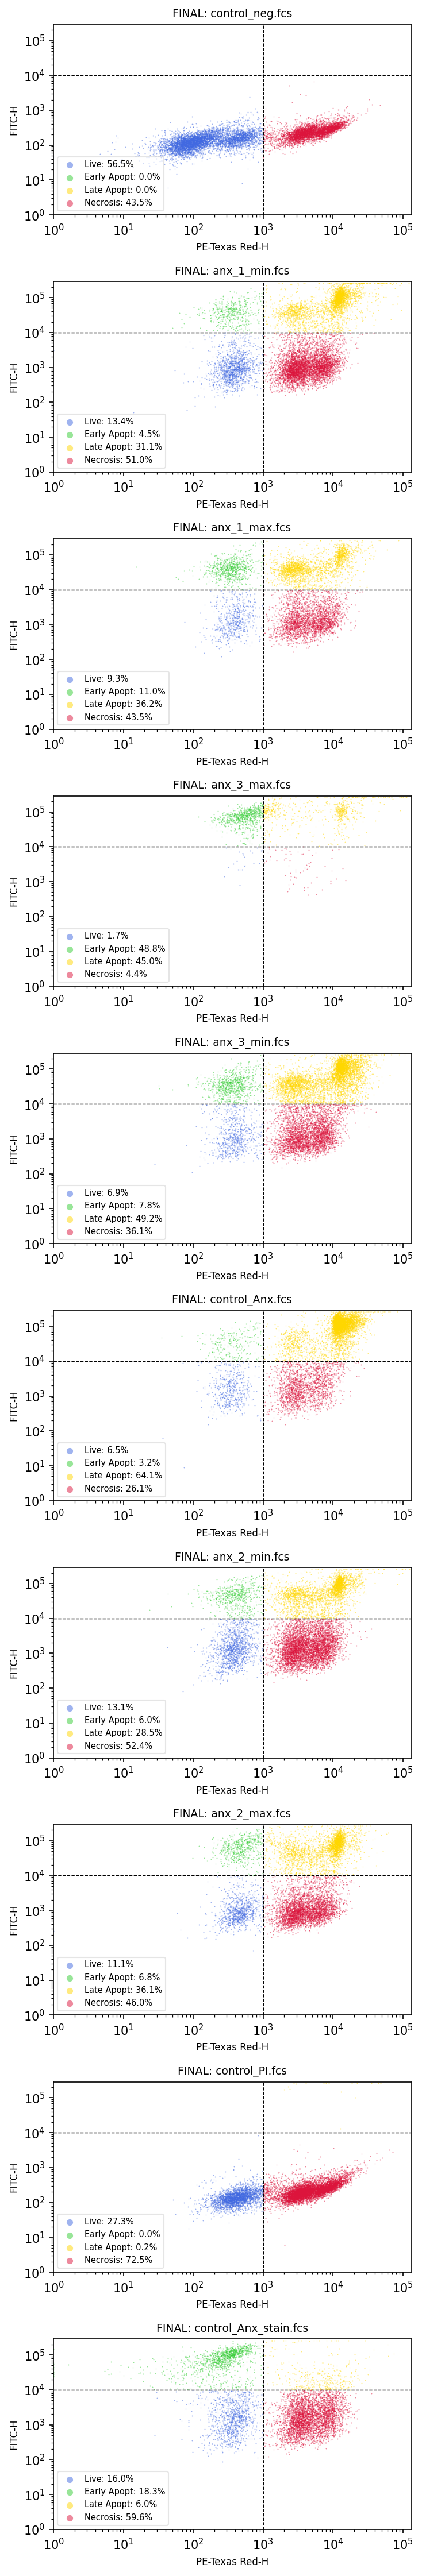

In [28]:
gate_pi = int(input("Порог PI (X): "))
gate_fitc = int(input("Порог FITC (Y): "))

# Сохраняем высокую четкость, но уменьшаем физический размер полотна
plt.rcParams['figure.dpi'] = 150 

# figsize=(5, 3 * num_samples) — теперь графики узкие и невысокие
fig, axes = plt.subplots(num_samples, 1, figsize=(5, 3 * num_samples))
if num_samples == 1: axes = [axes]

for i, sample in enumerate(filtered_samples):
    df_f = sample['df_comp']
    total = len(df_f)
    
    # Данные по секторам
    ll = df_f[(df_f[ch_pi] < gate_pi) & (df_f[ch_fitc] < gate_fitc)]
    ul = df_f[(df_f[ch_pi] < gate_pi) & (df_f[ch_fitc] >= gate_fitc)]
    ur = df_f[(df_f[ch_pi] >= gate_pi) & (df_f[ch_fitc] >= gate_fitc)]
    lr = df_f[(df_f[ch_pi] >= gate_pi) & (df_f[ch_fitc] < gate_fitc)]
    
    # Отрисовка без обводки (linewidths=0 для четкости)
    for q_data, q_color, q_lab in zip([ll, ul, ur, lr], 
                                     ['royalblue', 'limegreen', 'gold', 'crimson'],
                                     ['Live', 'Early Apopt', 'Late Apopt', 'Necrosis']):
        axes[i].scatter(q_data[ch_pi], q_data[ch_fitc], s=0.8, color=q_color, 
                        alpha=0.5, linewidths=0, label=f"{q_lab}: {len(q_data)/total*100:.1f}%")
    
    # Линии квадрантов
    axes[i].axvline(gate_pi, color='black', lw=0.7, ls='--')
    axes[i].axhline(gate_fitc, color='black', lw=0.7, ls='--')
    
    axes[i].set_xscale('log'); axes[i].set_yscale('log')
    axes[i].set_xlim(1, lim_pi); axes[i].set_ylim(1, lim_fitc)
    
    # Уменьшаем шрифты для компактности
    axes[i].set_title(f"FINAL: {sample['name']}", fontsize=9)
    axes[i].set_xlabel(ch_pi, fontsize=8)
    axes[i].set_ylabel(ch_fitc, fontsize=8)
    
    # Легенда поменьше
    axes[i].legend(markerscale=6, loc='lower left', fontsize=7, framealpha=0.5)

plt.tight_layout()
plt.show()

In [34]:
import pandas as pd

results = []
for sample in filtered_samples:
    df_f = sample['df_comp']
    total = len(df_f)
    
    # Считаем проценты для каждого образца
    res = {
        'Sample': sample['name'],
        'Live %': (len(df_f[(df_f[ch_pi] < gate_pi) & (df_f[ch_fitc] < gate_fitc)]) / total) * 100,
        'Early Apoptosis %': (len(df_f[(df_f[ch_pi] < gate_pi) & (df_f[ch_fitc] >= gate_fitc)]) / total) * 100,
        'Late Apoptosis %': (len(df_f[(df_f[ch_pi] >= gate_pi) & (df_f[ch_fitc] >= gate_fitc)]) / total) * 100,
        'Necrosis %': (len(df_f[(df_f[ch_pi] >= gate_pi) & (df_f[ch_fitc] < gate_fitc)]) / total) * 100
    }
    results.append(res)

# Сохраняем в таблицу
df_results = pd.DataFrame(results)
df_results.to_csv('analysis_results.csv', index=False)
print("Результаты сохранены в analysis_results.csv")
df_results

Результаты сохранены в analysis_results.csv


Sample     Live %  Early Apoptosis %  Late Apoptosis %  \
0        control_neg.fcs  56.503387           0.000000          0.009816   
1          anx_1_min.fcs  13.354985           4.507430         31.099301   
2          anx_1_max.fcs   9.283287          11.028730         36.206364   
3          anx_3_max.fcs   1.743796          48.826291         45.003353   
4          anx_3_min.fcs   6.867079           7.849494         49.150211   
5        control_Anx.fcs   6.502542           3.237891         64.128980   
6          anx_2_min.fcs  13.081909           5.981143         28.540562   
7          anx_2_max.fcs  11.132323           6.753371         36.081613   
8         control_PI.fcs  27.280806           0.000000          0.177725   
9  control_Anx_stain.fcs  16.022911          18.328683          6.006756   

   Necrosis %  
0   43.486797  
1   51.038284  
2   43.481619  
3    4.426559  
4   36.133215  
5   26.130586  
6   52.396386  
7   46.032693  
8   72.541469  
9   59.641651